# Cluster Archetypes — Visualization

This notebook loads the per-player aggregated features produced by `scripts/cluster_archetypes.py` (`data/player_archetypes.csv`) and visualizes clusters.

We re-run KMeans with k=5 (so you can inspect at least 5 archetypes) and produce: PCA scatter, cluster sizes, centroid heatmap, and a pairplot of top features.

If `data/player_archetypes.csv` doesn't exist, run `python3 scripts/cluster_archetypes.py` first in the repo root.

In [14]:
# Imports and plotting setup
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline
sns.set(style='whitegrid')

In [15]:
# Load the aggregated per-player data produced by the clustering script
fp = '/Users/christopherhsu/projects/hitterarchetypes/data/player_archetypes.csv'
df = pd.read_csv(fp)
print('Loaded', fp, 'with shape', df.shape)
df.head()

Loaded /Users/christopherhsu/projects/hitterarchetypes/data/player_archetypes.csv with shape (616, 18)


,batter,n_swings,launch_speed_mean,launch_speed_std,launch_speed_median,launch_speed_p95,pct_hard_hit,launch_angle_mean,launch_angle_std,bat_speed_mean,bat_speed_std,swing_length_mean,attack_angle_mean,swing_path_tilt_mean,intercept_ball_minus_batter_pos_x_inches_mean,intercept_ball_minus_batter_pos_y_inches_mean,attack_direction_mean,cluster
0,455117,105,81.338000,22.578992,87.50,105.255,0.266667,13.430000,32.184209,66.516129,16.464641,6.864516,7.750065,31.920187,37.246824,31.482141,358.008807,2
1,456781,145,87.657042,13.930259,90.45,103.990,0.372414,12.598592,25.896428,65.364815,5.034095,6.726852,6.057298,33.716937,35.023522,27.319626,0.923388,3
2,457705,373,89.403261,13.518230,92.75,105.365,0.423592,14.160326,27.525442,71.225602,4.798159,7.623795,13.693026,34.229937,38.666867,24.929984,0.832158,1
3,457759,143,88.303623,11.048337,91.45,103.430,0.300699,18.028986,25.172961,66.402419,4.700259,6.476613,9.819693,34.438291,32.616453,38.656329,0.331739,3
4,467793,344,88.137791,14.208057,89.70,106.470,0.389535,16.459302,30.150711,70.628053,5.800626,7.445215,10.945917,26.040130,38.047763,32.039333,359.059098,4


In [16]:
# Identify player id column and numeric feature columns
# We assume the first column is the player id (as produced by the script)
player_col = df.columns[0]
print('Assuming player id column:', player_col)
# select numeric columns as features (exclude any 'cluster' column if present)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'cluster' in num_cols:
    num_cols.remove('cluster')
print('Numeric feature columns detected:', num_cols)
# Build feature matrix X
X = df[num_cols].copy()
# Fill or drop NaNs sensibly
X = X.fillna(X.mean())
X.shape

Assuming player id column: batter
Numeric feature columns detected: ['batter', 'n_swings', 'launch_speed_mean', 'launch_speed_std', 'launch_speed_median', 'launch_speed_p95', 'pct_hard_hit', 'launch_angle_mean', 'launch_angle_std', 'bat_speed_mean', 'bat_speed_std', 'swing_length_mean', 'attack_angle_mean', 'swing_path_tilt_mean', 'intercept_ball_minus_batter_pos_x_inches_mean', 'intercept_ball_minus_batter_pos_y_inches_mean', 'attack_direction_mean']


(616, 17)

In [17]:
# Standardize and run PCA for 2D projection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print('Explained variance ratio (PC1, PC2):', pca.explained_variance_ratio_)

Explained variance ratio (PC1, PC2): [0.29459021 0.11110218]


In [18]:
# Run KMeans with k=5 (as requested) and attach labels
k = 5
km = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = km.fit_predict(X_scaled)
df['cluster_k5'] = labels
print('Cluster counts (k=5):')
print(df['cluster_k5'].value_counts().sort_index())

Cluster counts (k=5):
cluster_k5
0    136
1    126
2    113
3    147
4     94
Name: count, dtype: int64


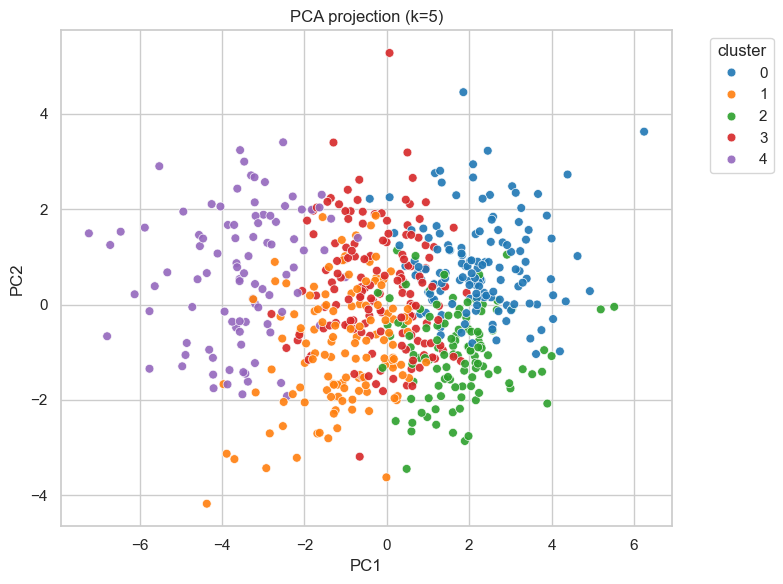

In [19]:
# PCA scatter colored by cluster
plt.figure(figsize=(8,6))
plot_df = pd.DataFrame({'PC1': X_pca[:,0], 'PC2': X_pca[:,1], 'cluster': labels, player_col: df[player_col]})
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=40, alpha=0.9)
plt.title('PCA projection (k=5)')
plt.legend(title='cluster', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

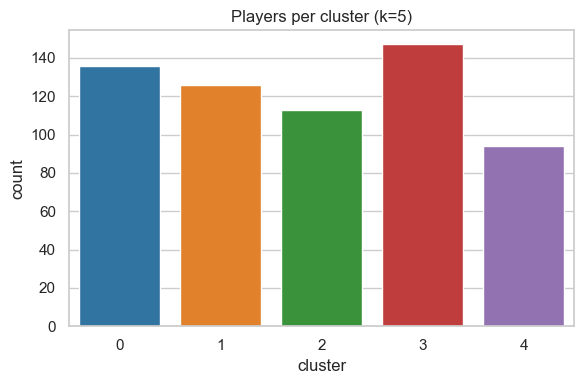

In [20]:
# Bar chart of cluster sizes
plt.figure(figsize=(6,4))
counts = df['cluster_k5'].value_counts().sort_index()
sns.barplot(x=counts.index.astype(str), y=counts.values, palette='tab10')
plt.xlabel('cluster')
plt.ylabel('count')
plt.title('Players per cluster (k=5)')
plt.tight_layout()
plt.show()

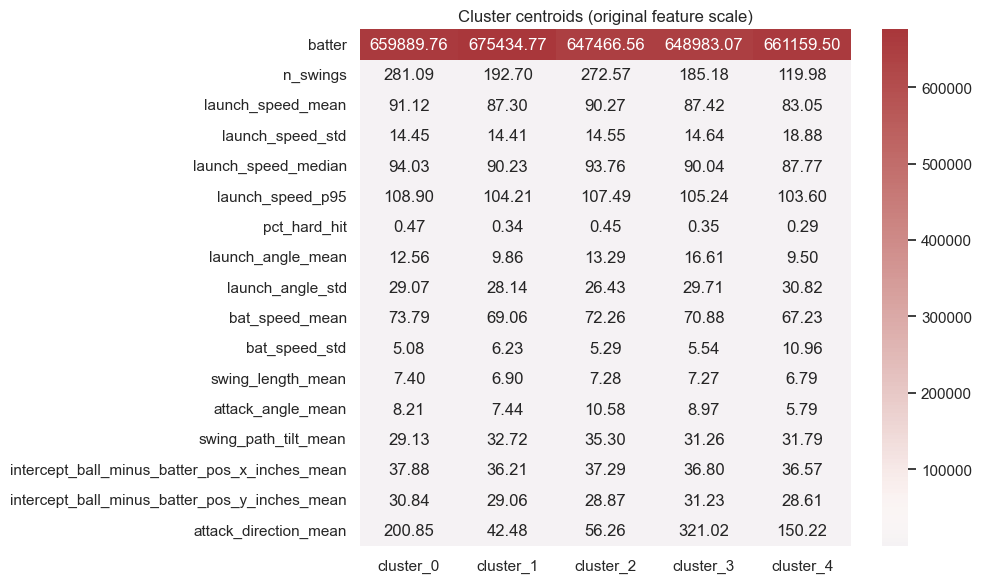

In [21]:
# Cluster centroids heatmap (in original feature scale)
centroids_orig = pd.DataFrame(scaler.inverse_transform(km.cluster_centers_), columns=num_cols)
centroids_orig.index = [f'cluster_{i}' for i in range(k)]
plt.figure(figsize=(10,6))
sns.heatmap(centroids_orig.T, cmap='vlag', center=centroids_orig.values.mean(), annot=True, fmt='.2f')
plt.title('Cluster centroids (original feature scale)')
plt.tight_layout()
plt.show()

Top 4 features by variance: ['batter', 'attack_direction_mean', 'n_swings', 'launch_angle_mean']


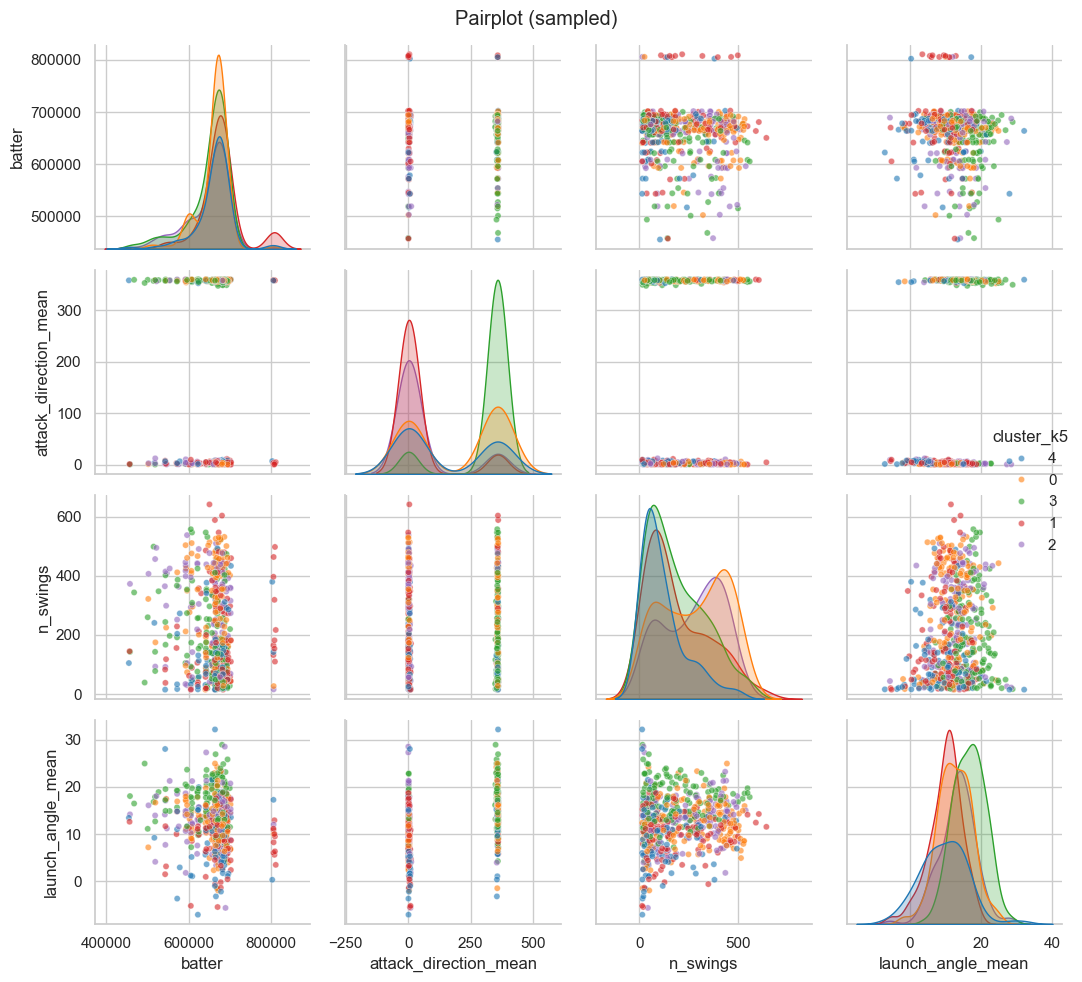

In [22]:
# Pairplot of the top 4 most variable features colored by cluster
variances = X.var().sort_values(ascending=False)
top4 = variances.head(4).index.tolist()
print('Top 4 features by variance:', top4)
pp_df = df[top4 + ['cluster_k5']].copy()
pp_df['cluster_k5'] = pp_df['cluster_k5'].astype(str)
# seaborn pairplot can be slow for many points; sample if needed
sampled = pp_df.sample(n=min(1000, len(pp_df)), random_state=42)
sns.pairplot(sampled, vars=top4, hue='cluster_k5', palette='tab10', plot_kws={'s':20, 'alpha':0.6})
plt.suptitle('Pairplot (sampled)')
plt.tight_layout()
plt.show()